In [1]:
import numpy as np
from scipy.io import loadmat
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
os.environ['SIR_CONFIG_DIR'] = "/content/gdrive/My Drive/bioface"
%cd /content/gdrive/My Drive/bioface

/content/gdrive/My Drive/bioface


In [4]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

def conv3x3(in_channels, out_channels, kernel_size, stride, dilation, padding):
	return nn.Conv2d(in_channels, out_channels, kernel_size,stride, dilation, padding)

def conv(in_channels, out_channels, kernel_size, bias= False, padding = 1, stride = 1):
	return nn.Conv2d(in_channels, out_channels, kernel_size, padding= (kernel_size//2), bias = bias, stride = stride)


class SingleConv(nn.Module):
	def __init__(self, in_channels, out_channels, kernel_size, stride = 1, padding = 1, dilation = 1, groups = 1, relu = True, bn = True, bias = False):
		super(SingleConv, self).__init__()
		self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride, padding = padding, dilation = dilation, groups = groups, bias = bias)
		self.bn = nn.BatchNorm2d(out_channels, eps = 1e-5, momentum = 0.01, affine = True) if bn else None
		self.relu = nn. ReLU() if relu else None

	def forward(self, x):
		x = self.conv(x)
		if self.bn is not None:
			x = self.bn(x)
		if self.relu is not None:
			x = self.relu(x)
		return x

class TripleConv(nn.Module):
	def __init__(self, in_channels, out_channels, kernel_size, stride = 1, padding = 1, dilation = 1, groups = 1, relu = True, bias = False):
		super(TripleConv, self).__init__()
		self.conv = nn.Sequential(
			nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride, padding = padding, dilation = dilation, groups = groups, bias = bias),
			nn.BatchNorm2d(out_channels, eps = 1e-5, momentum = 0.01, affine = True),
			nn.ReLU(inplace = True),
			nn.Conv2d(out_channels, out_channels, kernel_size = kernel_size, stride = stride, padding = padding, dilation = dilation, groups = groups, bias = bias),
			nn.BatchNorm2d(out_channels, eps = 1e-5, momentum = 0.01, affine = True),
			nn.ReLU(inplace = True),
			nn.Conv2d(out_channels, out_channels, kernel_size = kernel_size, stride = stride, padding = padding, dilation = dilation, groups = groups, bias = bias),
			nn.BatchNorm2d(out_channels, eps = 1e-5, momentum = 0.01, affine = True),
			nn.ReLU(inplace = True)
		)
	def forward(self, x):
		x = self.conv(x)
		return x

class Encoder(nn.Module):
	def __init__(self,in_channels):
		super(Encoder, self).__init__()
		self.layer1 = TripleConv(in_channels,32,3)
		self.layer2 = TripleConv(32,64,3)
		self.layer3 = TripleConv(64,128,3)
		self.layer4 = TripleConv(128,256,3)
		self.layer5 = TripleConv(256,512,3)
		self.mp = nn.MaxPool2d(2,stride = 2)
	def forward(self, x):
		x1  = self.layer1(x)
		x1d = self.mp(x1)
		x2  = self.layer2(x1d)
		x2d = self.mp(x2)
		x3  = self.layer3(x2d)
		x3d = self.mp(x3)
		x4  = self.layer4(x3d)
		x4d = self.mp(x4)
		x5  = self.layer5(x4d)
		return x1,x2,x3,x4,x5

class Up(nn.Module):
	def __init__(self ,in_channels ,out_channels, bilinear = False):
		super(Up, self).__init__()
		if bilinear:
			self.up = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corner = True)
		else:
			self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, stride = 2)
		self.conv = TripleConv(out_channels,out_channels, 3)
	def forward(self, x1, x2):
		x1 = self.up(x1)

		#to resolve padding issue
		diffY = x2.size()[2] - x1.size()[2]
		diffX = x2.size()[3] - x1.size()[3]

		x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
						diffY // 2, diffY - diffY //2))

		#using add instead of concat to reduce complexity
		x = torch.add(x2,x1)
		x = self.conv(x)
		return x

class Decoder(nn.Module):
	def __init__(self, out_channels):
		super(Decoder, self).__init__()
		self.up1 = Up(512,256)
		self.up2 = Up(256,128)
		self.up3 = Up(128,64)
		self.up4 = Up(64,32)
		self.up5 = conv(32, out_channels, 3)

	def forward(self, x1, x2, x3, x4, x5):
		x = self.up1(x5,x4)
		x = self.up2(x, x3)
		x = self.up3(x, x2)
		x = self.up4(x, x1)
		x = self.up5(x)
		return x

class MultipleDecoder(nn.Module):
	def __init__(self, in_channels = 3 ,out_channels = 1):
		super(MultipleDecoder, self).__init__()
		self.lightVectorLSize = 15
		self.bsize = 2
		self.enc  = Encoder(in_channels)
		self.dec1 = Decoder(out_channels)
		self.dec2 = Decoder(out_channels)
		self.dec3 = Decoder(out_channels)		
		self.dec4 = Decoder(out_channels)
		self.fc1  = SingleConv(512,512,3)  # in code kernel size is given as 4
		self.fc2  = nn.Linear(8192,512,1)  # FC layer
		self.fc3  = nn.Linear(512,self.lightVectorLSize + self.bsize,1)  # FC layer for lighting and camera parameter+ lighting condition

	def forward(self, x):
		x1,x2,x3,x4,x5 = self.enc(x)
		fmel     = self.dec1(x1,x2,x3,x4,x5)
		fblood   = self.dec2(x1,x2,x3,x4,x5)
		Shading  = self.dec3(x1,x2,x3,x4,x5)
		specmask = self.dec4(x1,x2,x3,x4,x5)

		y1 = self.fc1(x5)
		y1 = torch.flatten(y1, 1)
		# print(y1.size())
		y2 = self.fc2(y1)
		y3 = self.fc3(y2)
		# b,ch,h,w
		lightingparameters = y3[:,0:self.lightVectorLSize]
		nbatch = y3.size()[0]
		lightingparameters = torch.reshape(lightingparameters, (nbatch,self.lightVectorLSize,1,1))
		# print(y3.size())
		b = torch.reshape( y3[:,self.lightVectorLSize:self.lightVectorLSize + self.bsize], (nbatch, self.bsize,1,1))
		return lightingparameters,b,fmel,fblood,Shading,specmask

def Net():
  model = MultipleDecoder(in_channels = 3 ,out_channels = 1)
  return model


In [5]:
import numpy as np
import cv2,os,math,sys
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import Adam
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def load_matfiles(data_path):
	illF = loadmat(data_path + 'illF.mat')
	illF = illF['illF']  # 1x 33 x 12
	
	illumDmeasured = loadmat(data_path + 'illumDmeasured.mat')
	illumDmeasured = illumDmeasured['illumDmeasured']	

	illumA = loadmat(data_path + 'illumA.mat')
	illumA = illumA['illumA']

	Newskincolour = loadmat(data_path + 'Newskincolour.mat')
	Newskincolour = Newskincolour['Newskincolour']

	rgbCMF = loadmat(data_path + 'rgbCMF.mat')
	rgbCMF = rgbCMF['rgbCMF']

	Tmatrix = loadmat(data_path + 'Tmatrix.mat')
	Tmatrix = Tmatrix['Tmatrix']

	XYZspace = loadmat(data_path + 'XYZspace.mat')
	XYZspace = XYZspace['XYZspace']

	return illF, illumDmeasured, illumA, Newskincolour, rgbCMF, Tmatrix, XYZspace
# to scale the parameter 
def ScaleNet(lightingparameters,b,fmel,fblood,Shading,specmask,bSize):
#     weightA  : B x 1 x 1 x 1  
#     weightD  : B x 1 x 1 x 1  
#     CCT      : B x 1 x 1 x 1  
#     Fweights : B x 12 x 1 x 1  
#     b        : B x 2 x 1 x 1  
#     fmel     : B x 1 x 224 x 224  
#     fblood   : B x 1 x 224 x 224  
#     Shading  : B x 1 x 224 x 224  
#     specmask : B x 1 x 224 x 224  
#     bSize    : 2
  nbatch = lightingparameters.size()[0]
  m = nn.Softmax(dim=1)
  lightingweights = m(lightingparameters[:,0:14,:,:])
  weightA  = lightingweights[:,0,:,:]
  weightA = torch.unsqueeze(weightA,1)
  weightD  = lightingweights[:,1,:,:]
  weightD = torch.unsqueeze(weightD,1)
  Fweights = lightingweights[:,2:14,:,:]
  CCT      =  lightingparameters[:,14,:,:]
  CCT      = ((22 - 1) / (1 + torch.exp(-CCT))) + 1;
  CCT = torch.unsqueeze(CCT,1)
  b = 6.*(torch.sigmoid(b))-3
  BGrid = torch.reshape(b,(bSize,1,1,nbatch)) # 2 x 1 x 1 x B check this reshape
  BGrid = BGrid / 3
  fmel = torch.sigmoid(fmel) *2 -1
  fblood = torch.sigmoid(fblood) * 2 -1
  Shading = torch.exp(Shading)
  specmask = torch.exp(specmask)
  return weightA,weightD,CCT,Fweights,b,BGrid,fmel,fblood,Shading,specmask

# create the illumination model from CIE standard illuminants: A,D,F
# extract illumA,illumDNorm,illumFNorm foom mat files in util
def illuminationModel(weightA,weightD,Fweights,CCT,illumA,illumDNorm,illumFNorm):
#     weightA    : B x 1 x 1 x 1 
#     weightD    : B x 1 x 1 x 1
#     CCT        : B x 1 x 1 x 1
#     Ftype      : B x 12 x 1 x 1 
#     illumA     : 1 x 1 x 33 x B
#     illumDNorm : 1 x 1 x 33 x 22
#     illumFNorm : 1 x 1 x 33 x 12
  illumA = illumA.permute(3,2,0,1)  # B x 33 x 1 x 1
  # print(illumA.size(),weightA.size())
  illuminantA = illumA * weightA # B x 33 x 1 x 1

  # don't know this layer. check where function vl_nnillumD is defined 
  # illumDlayer = Layer.fromFunction(@vl_nnillumD);
  # illD   = illumDlayer(CCT,illumDNorm);
  # illuminantD = illD.*weightD;

  # illuminantD should be converted to B x 33 x 1 x 1
  illumDNorm = illumDNorm.permute(3,2,0,1) # 22 x 33 x 1 x 1
  illumDNorm = torch.unsqueeze(torch.sum(illumDNorm,0),0) # 1 x 33 x 1 x 1
  # print(illumDNorm.size(),CCT.size(),weightD.size())
  illuminantD = CCT*illumDNorm*weightD  

  illumFNorm = illumFNorm.permute(0,2,3,1) #permute to 1 x 33 x 12 x 1
  Fweights = Fweights.permute(2,3,1,0)
  illuminantF = illumFNorm*Fweights # 1 x 33 x 12 x B
  illuminantF = torch.unsqueeze(torch.sum(illuminantF,2),2) # check if dimension is reduced 1 x 33 x 1 x B
  illuminantF = illuminantF.permute(3,1,0,2) # B x 33 x 1 x 1
  e = illuminantA + illuminantD +illuminantF
  esum = torch.unsqueeze(torch.sum(e,1),1) # sum across channel
  e = e / esum

  return e

def cameraModel(mu,PC,b,wavelength):
# Inputs:
#     mu         : B x 1 x 1 x 1 
#     PC         : B x 1 x 1 x 1 ?? actually is 99 x 2
#     b          : B x 2 x 1 x 1 
#     wavelength : 33

# Outputs:
#     Sr,Sg,Sb   : B x 33 x 1 x 1

    nbatch = b.size()[0]
    ## PCA model
    b = torch.reshape(b,(nbatch,2)).float()
    PC = torch.reshape(PC,(99,2)).float()
    # print(b.size(),PC.size())
    S = torch.matmul(PC,torch.transpose(b, 0, 1))  # 99 x nbatch
    mu = torch.unsqueeze(mu,1)
    S = S + mu  
    rel = nn.ReLU()
    S =  rel(S)
    S = torch.transpose(S, 0, 1)
    # print(S.size())
    wavelength = wavelength.int()    
    ## split up S into Sr, Sg, Sb 
    Sr = torch.reshape(S[:,0:wavelength],(nbatch, wavelength, 1, 1))                  
    Sg = torch.reshape(S[:,wavelength:wavelength*2],(nbatch, wavelength, 1, 1))     
    Sb = torch.reshape(S[:,wavelength*2:wavelength*3],(nbatch, wavelength, 1, 1))

    return Sr,Sg,Sb 

def CameraSensitivityPCA(rgbCMF):

  X = np.zeros((99,28))
  Y = np.zeros((99,28))
  redS = rgbCMF[0,0]
  greenS= rgbCMF[0,1]
  blueS = rgbCMF[0,2]
  for i in range(0,28):
    Y[0:33,i]  = redS[:,i] / np.sum(redS[:,i])
    Y[33:66,i] = greenS[:,i] / np.sum(greenS[:,i])
    Y[66:99,i] = blueS[:,i] / np.sum(blueS[:,i])
  pca = PCA(n_components=28)
  pca.fit(Y.T)
  PC = pca.components_    # 99,27
  EV = pca.explained_variance_  # 27,1
  mu = pca.mean_  # 1,99
  PC = np.matmul(PC.T[:,0:2],np.diag(np.sqrt(EV[0:2])))
  EV = EV[0:2]
  # [PC,~,EV,~,explained,mu] = pca(Y')
  # PC = single(PC(:,1:2)*diag(sqrt(EV(1:2)))) # 99,2  
  # mu = single(mu')  # 99,1
  # EV = single(EV(1:2)) # 2,1
  return mu,PC,EV

def computelightcolour(e,Sr,Sg,Sb):
# Inputs:
#     Sr,Sg,Sb         : B x 33 x 1 x 1 
#     e                : B x 33 x 1 x 1
#  Output:
#  lightcolour         : Bx 3 x 1 x 1 
  lightcolour  = torch.cat((torch.sum(Sr * e,1), torch.sum(Sg * e,1), torch.sum(Sb * e,1)),1)
  lightcolour = torch.unsqueeze(lightcolour,2)
  return lightcolour

def computeSpecularities(specmask,lightcolour):
# Inputs:
#     specmask          : B x 1 x H x W 
#     lightcolour      : B x 3 x 1 x 1 
#  Output:
#     Specularities    : B x 1 x H x W 
##
	Specularities = specmask * lightcolour
	return  Specularities 

def BiotoSpectralRef(fmel,fblood,Newskincolour):
# Inputs:
#     fmel             : B x 1 x H x W 
#     fblood           : B x 1 x H x W
#     Newskincolour    : B x 33 x 256 x 256 
#  Output:
#     R_total          : B x 33 x H x W 
##
	BiophysicalMaps = torch.cat((fblood,fmel),1) # B x 2 x H x W 
	BiophysicalMaps = BiophysicalMaps.permute(0, 2, 3, 1) # for troch grid shape should be B x H x W x 2  


	R_total  = nn.functional.grid_sample(Newskincolour, BiophysicalMaps, mode='bilinear')
	return R_total 

def ImageFormation (R_total, Sr,Sg,Sb,e,Specularities,Shading):
	#Inputs:,
	#     R_total       : nbatch X 33 X H X W 
	#     Shading       : nbatch X 1 X H X W 
	#     Specularities : nbatch X 1 X H X W 
	#     Sr,Sg,Sb      : nbatch x 33 x 1 x 1 
	#     e             : nbatch x 33 x 1 x 1 
	# Output:
	#     rgbim : nbatch x 1 x H x  W 
	#---------------------------Image Formation -------------------------------
	spectraRef = R_total * e # nbatch X 33 X H X W  
	#--------------------------------------------------------------------------
	rChannel = torch.unsqueeze(torch.sum(spectraRef * Sr,1),1)  
	gChannel = torch.unsqueeze(torch.sum(spectraRef * Sg,1),1)  
	bChannel = torch.unsqueeze(torch.sum(spectraRef * Sb,1),1)  

	diffuseAlbedo = torch.cat((rChannel,gChannel,bChannel),1)  # nbatch x 3 x H x W 

	#---------------------------Shaded Diffuse --------------------------------

	ShadedDiffuse = diffuseAlbedo * Shading  # nbatch x 3 x H x W

	# ShadedDiffuse = torch.unsqueeze(torch.sum(ShadedDiffuse,1),1) #added for dimension correction
	#---------------------------Raw appearance --------------------------------
	rawAppearance = ShadedDiffuse + Specularities 
	return rawAppearance,diffuseAlbedo  

def WhiteBalance(rawAppearance,lightcolour):
# Inputs:
#     rawAppearance    : B x 3 x H x W 
#     lightcolour      : B x 3 x 1 x 1  
#  Output:
#     ImwhiteBalanced  : B x 3 x H x W 
## --------------------------- White Balance ------------------------------
	WBrCh = torch.unsqueeze(rawAppearance[:,0,:,:]/lightcolour[:,0,:,:],1)  
	WBgCh = torch.unsqueeze(rawAppearance[:,1,:,:]/lightcolour[:,1,:,:],1)
	WBbCh = torch.unsqueeze(rawAppearance[:,2,:,:]/lightcolour[:,2,:,:],1)
	ImwhiteBalanced = torch.cat((WBrCh,WBgCh,WBbCh),1)
	return ImwhiteBalanced

def findT(Tmatrix,BGrid):
# Inputs:
#     Tmatrix          : 128 x 128 x 9 
#     BGrid            : 2 x 1 x 1 x B 
#  Output:
#     T_RAW2RGB        :  B x 9 x 1 x 1
##
    # to make dimesion B x 9 x 128 x 128
	nbatch = BGrid.size()[3] 
	Tmatrix = torch.unsqueeze(Tmatrix,0)
	Tmatrix = Tmatrix.permute(0,3,1,2) # 1 x 9 x 128 x 128
	Tmatrix = Tmatrix.repeat(nbatch,1,1,1) # B x 9 x 128 x 128

	BGrid = BGrid.permute(3,1,2,0) # B x 1 x 1 x 2 to match grid dimension
	
	T_RAW2XYZ =  nn.functional.grid_sample(Tmatrix,BGrid, mode='bilinear')
	#T_RAW2RGB.name ='T_RAW2RGB';
	return T_RAW2XYZ

def fromRawTosRGB(imWB,T_RAW2XYZ):

# Inputs:
#     imWB: B X 3 X H X W  
#     T_RAW2RGB  :  B x 9 x 1 x 1
# Output:
#     sRGBim : B X 3 X H X W
##
	Ix = T_RAW2XYZ[:,0,:,:] * imWB[:,0,:,:] + T_RAW2XYZ[:,3,:,:] * imWB[:,1,:,:] + T_RAW2XYZ[:,6,:,:] * imWB[:,2,:,:] # B X 1 X H X W
	Iy = T_RAW2XYZ[:,1,:,:] * imWB[:,0,:,:] + T_RAW2XYZ[:,4,:,:] * imWB[:,1,:,:] + T_RAW2XYZ[:,7,:,:] * imWB[:,2,:,:] 
	Iz = T_RAW2XYZ[:,2,:,:] * imWB[:,0,:,:] + T_RAW2XYZ[:,5,:,:] * imWB[:,1,:,:] + T_RAW2XYZ[:,8,:,:] * imWB[:,2,:,:] 
	Ix = torch.unsqueeze(Ix,1)
	Iy = torch.unsqueeze(Iy,1)
	Iz = torch.unsqueeze(Iz,1)
	Ixyz = torch.cat((Ix,Iy,Iz),1) # B X 3 X H X W
	Txyzrgb = torch.tensor([3.2406, -1.5372, -0.4986, -0.9689, 1.8758, 0.0415, 0.0557, -0.2040, 1.057 ])

	# if isa(imWB, 'Layer')
	#   Txyzrgb = Param('value',Txyzrgb,'learningRate',0); Txyzrgb.name='Txyzrgb';
	# end 

	R = Txyzrgb[0] * Ixyz[:,0,:,:] + Txyzrgb[3] * Ixyz[:,1,:,:] + Txyzrgb[6] * Ixyz[:,2,:,:]  # R
	G = Txyzrgb[1] * Ixyz[:,0,:,:] + Txyzrgb[4] * Ixyz[:,1,:,:] + Txyzrgb[7] * Ixyz[:,2,:,:]  # G
	B = Txyzrgb[2] * Ixyz[:,0,:,:] + Txyzrgb[5] * Ixyz[:,1,:,:] + Txyzrgb[8] * Ixyz[:,2,:,:]  # B

	R = torch.unsqueeze(R,1)
	G = torch.unsqueeze(G,1)
	B = torch.unsqueeze(B,1)
	sRGBim = torch.cat((R,G,B),1)
	rel = nn.ReLU()
	sRGBim =  rel(sRGBim)
	return sRGBim 



In [6]:
from torch.utils.data import Dataset
from torchvision import transforms
from scipy import misc
import numpy as np
import imageio
import torch
import os

to_tensor = transforms.Compose([
    transforms.ToTensor()
])

class LoadData(Dataset):

  def __init__(self, dataset_dir = './zx_7_d10_inmc_celebA_01.hdf5', test=False):

    filename = dataset_dir
    with h5py.File(filename, "r") as f:
      # List all groups
      a_group_key = list(f.keys())[0]
      # Get the data
      self.data = list(f[a_group_key])        

    self.dataset_size = len(self.data)

  def __len__(self):
    return self.dataset_size

  def __getitem__(self, idx):
    itm = self.data[idx]
    image = np.asarray(itm[0:3,:,:])

    diffuse = np.asarray(itm[3:4,:,:])

    mask =  np.asarray(itm[6:7,:,:])

    return image, diffuse, mask

In [7]:
import numpy as np
import cv2,os,math,sys
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import Adam
import torch
import torch.nn as nn
import imageio
from scipy import misc
import h5py

to_image = transforms.Compose([transforms.ToPILImage()])
dataset_dir = '/content/gdrive/My Drive/bioface/sample.hdf5'
data_path = '/content/gdrive/My Drive/bioface/'
batch_size = 1
weight_path = '/content/gdrive/My Drive/bioface/models/cnn_epoch_62.pth'
# imavg = np.array([327.1863,-0.7624,93.5940])
def test_model():

	illF, illumDmeasured, illumA, Newskincolour, rgbCMF, Tmatrix, XYZspace = load_matfiles(data_path)
	Newskincolour = np.transpose(Newskincolour, (2, 0, 1))  # 256x 256 X 33 -> 33 X 256 X 256
	Newskincolour = np.tile(Newskincolour,(batch_size,1,1,1))
	mu,PC,EV = CameraSensitivityPCA(rgbCMF)
	LightVectorSize = 15
	wavelength = torch.tensor(33.)
	bSize = torch.tensor(2)
	illF = illF.reshape((1,1,33,12))
	illumDmeasured = illumDmeasured.T.reshape((1,1,33,22))
	illumA = illumA.astype(np.float32) / np.sum(illumA)             # 1,1,33
	illumA = np.expand_dims(illumA, axis=3)
	illumA = np.tile(illumA,(1,1,1,batch_size))  # additional line
	illumDNorm = illumDmeasured.astype(np.float32)
	for i in range(0,22):
		illumDNorm[:,:,:,i] = illumDmeasured[:,:,:,i] / np.sum(illumDmeasured[:,:,:,i])

	illumFNorm = illF.astype(np.float32)
	for i in range(0,12):
		illumFNorm[:,:,:,i] = illF[:,:,:,i] / np.sum(illF[:,:,:,i])

	celebaimdb_averageImage = torch.tensor([129.1863,104.7624,93.5940])
	muim = torch.reshape(celebaimdb_averageImage,(1,3,1,1))
	bSize = 2

	illumA = torch.from_numpy(illumA).cuda()
	illumDNorm = torch.from_numpy(illumDNorm).cuda()
	illumFNorm = torch.from_numpy(illumFNorm).cuda()
	mu = torch.from_numpy(mu).cuda()
	PC = torch.from_numpy(PC).cuda()
	Newskincolour = torch.from_numpy(Newskincolour).cuda()
	Tmatrix = torch.from_numpy(Tmatrix).cuda()
	print("pre proc done")

	torch.backends.cudnn.deterministic = True
	device = torch.device("cuda")

	test_dataset = LoadData(dataset_dir, test=False)
	test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=1,
						  pin_memory=True, drop_last=True)
	model = MultipleDecoder() 
	model = torch.nn.DataParallel(model) # multi GPU
	model.load_state_dict(torch.load(weight_path), strict=True)
	model.eval()
	with torch.no_grad():

		test_iter = iter(test_loader)
	
	for j in range(0,3):
			print("Processing image " + str(j))
			torch.cuda.empty_cache()
			images, actualshading, actualmasks = next(test_iter)
			images = images.to(device, non_blocking=True).float()
			actualshading = actualshading.to(device, non_blocking=True)
			actualmasks = actualmasks.to(device, non_blocking=True)
			lightingparameters,b,fmel,fblood,Shading,specmask = model(images)

			weightA,weightD,CCT,Fweights,b,BGrid,fmel,fblood,Shading,specmask = ScaleNet(lightingparameters,b,fmel,fblood,Shading,specmask,bSize)
			e = illuminationModel(weightA,weightD,Fweights,CCT,illumA,illumDNorm,illumFNorm)
			Sr,Sg,Sb = cameraModel(mu.float(),PC.float(),b,wavelength)
			lightcolour = computelightcolour(e,Sr.float(),Sg.float(),Sb.float())
			Specularities = computeSpecularities(specmask,lightcolour)
			R_total = BiotoSpectralRef(fmel,fblood,Newskincolour)
			rawAppearance,diffuseAlbedo = ImageFormation (R_total, Sr,Sg,Sb,e,Specularities,Shading)
			ImwhiteBalanced = WhiteBalance(rawAppearance,lightcolour)
			T_RAW2XYZ = findT(Tmatrix,BGrid)
			sRGBim = fromRawTosRGB(ImwhiteBalanced,T_RAW2XYZ)
			# rel = nn.ReLU()
			# sRGBim = rel(sRGBim)
			sRGBim = np.asarray(torch.squeeze(sRGBim.float().detach().cpu()))
			sRGBim = sRGBim.transpose(1,2,0).astype(np.float32)
   
			images = np.asarray(torch.squeeze(images.float().detach().cpu())).transpose(1,2,0)
			sRGBim[:,:,0] = ((sRGBim[:,:,0] - np.amin(sRGBim[:,:,0])) / np.amax(sRGBim[:,:,0])) * 255
			sRGBim[:,:,1] = ((sRGBim[:,:,1] - np.amin(sRGBim[:,:,1])) / np.amax(sRGBim[:,:,1])) * 255
			sRGBim[:,:,2] = ((sRGBim[:,:,2] - np.amin(sRGBim[:,:,2])) / np.amax(sRGBim[:,:,2])) * 255
			color = ('b','g','r')
			for i,col in enumerate(color):
				histr = cv2.calcHist([sRGBim],[i],None,[256],[0,256])
				plt.plot(histr,color = col)
				plt.xlim([0,256])
			plt.show()
			print(np.amax(sRGBim[:,:,0]),np.amax(sRGBim[:,:,1]),np.amax(sRGBim[:,:,2]))

			# sRGBim = sRGBim - imavg

			images = images * 255
			color = ('b','g','r')
			for i,col in enumerate(color):
				histr = cv2.calcHist([images],[i],None,[256],[0,256])
				plt.plot(histr,color = col)
				plt.xlim([0,256])
			plt.show()
			# sRGBim = sRGBim * 255
			sRGBim = sRGBim.astype(np.uint8) 
			images = images.astype(np.uint8) 

			plt.imshow(sRGBim)
			plt.show()
			plt.imshow(images)
			plt.show()

			print(sRGBim.shape,np.amax(sRGBim[:,:,0]),np.amax(sRGBim[:,:,1]),np.amax(sRGBim[:,:,2]),np.amax(images[:,:,0]),np.amax(images[:,:,1]),np.amax(images[:,:,2]))
			Shading = np.asarray(to_image(torch.squeeze(Shading.float().detach().cpu())))
			Specularities = np.asarray(to_image(torch.squeeze(Specularities.float().detach().cpu())))
			fmel = np.asarray(to_image(torch.squeeze(fmel.float().detach().cpu())))
			fblood = np.asarray(to_image(torch.squeeze(fblood.float().detach().cpu())))
			actualshading = np.asarray(to_image(torch.squeeze(actualshading.float().detach().cpu())))
			actualmasks = np.asarray(to_image(torch.squeeze(actualmasks.float().detach().cpu())))

			imageio.imwrite("results/" + str(j) + "_recons_.png", sRGBim)
			imageio.imwrite("results/" + str(j) + "_input_.png", images)


pre proc done
Processing image 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


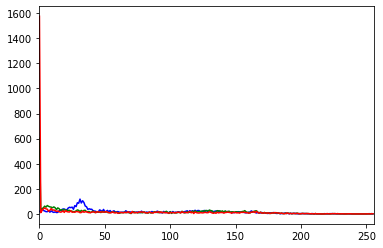

253.03113 255.0 255.0


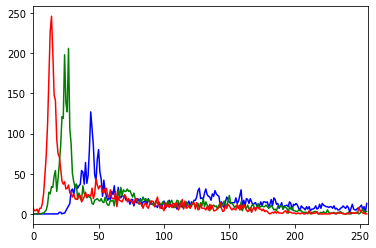

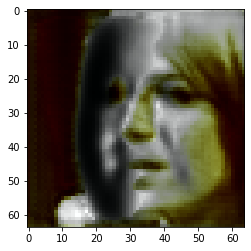

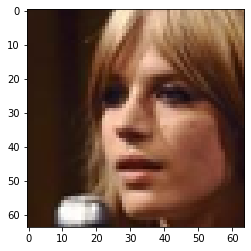

(64, 64, 3) 253 255 255 255 255 253
Processing image 1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


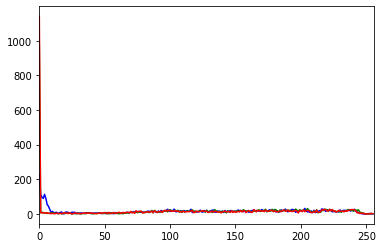

253.23987 255.0 255.0


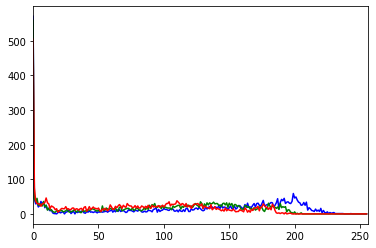

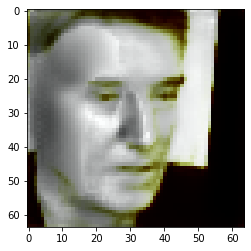

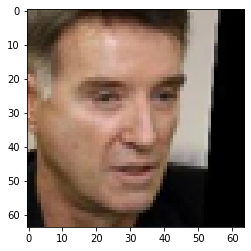

(64, 64, 3) 253 255 255 243 205 197
Processing image 2


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


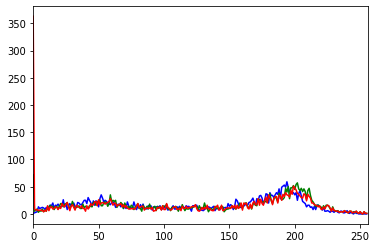

248.07585 255.0 255.0


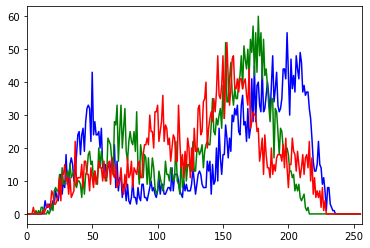

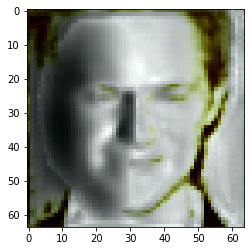

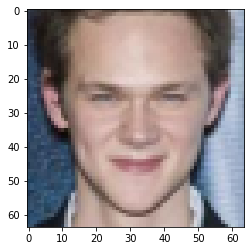

(64, 64, 3) 248 255 255 235 215 228


In [8]:
test_model()